# Introduction

This project is centered on uncovering the factors that drive sales in the cinema industry. Leveraging advanced machine learning methods like Random Forest and Gradient Boosting, the goal is to identify key elements influencing cinema revenue.


## Objective

The primary objective here is to understand which variables significantly impact cinema sales. The analysis will delve into various aspects of cinema data, aiming to uncover the influences on consumer behavior and ticket sales.


## Dataset Overview

The dataset was downloaded from Kaggle at https://www.kaggle.com/datasets/arashnic/cinema-ticket/dataoffers.  It offers a comprehensive view of cinema sales across multiple venues during 2018, encompassing a wide range of data points from ticket sales to seating capacities.

### Key Features Include:

- **film_code**: A unique identifier for each film shown.
- **cinema_code**: A unique identifier for each cinema venue.
- **total_sales**: The total revenue generated from each screening.
- **tickets_sold**: Number of tickets sold for each show.
- **tickets_out**: Count of tickets that were canceled.
- **show_time**: The schedule for each film screening.
- **occu_perc**: The percentage of occupied seats in the cinema.
- **ticket_price**: The cost of tickets for each show.
- **ticket_use**: The actual number of tickets used by the audience.
- **capacity**: The seating capacity of the cinema.
- **date**: The specific date of each screening.
- **month**: The month in which the screening took place.
- **quarter**: The business quarter of each screening event.
- **day**: The day of the week the film was shown.

This detailed dataset forms the foundation of an analysis aimed at revealing trends and patterns that influence cinema sales.



## Import Libraries

In [5]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from datetime import datetime, timedelta
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt
import time
from scipy import stats  # Import the stats module from scipy


# Record time it takes to run code
start_time = time.time()

# Set default style
plt.style.use('ggplot')

# Set the color palette
sns.set_palette("deep")

# Suppress future warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


## Load and Preprocess Data

In [7]:
# read initial datatypes
initial_df = pd.read_csv('../data/cinemaTicket_Ref.csv')

# check dtypes
initial_df.dtypes

film_code         int64
cinema_code       int64
total_sales       int64
tickets_sold      int64
tickets_out       int64
show_time         int64
occu_perc       float64
ticket_price    float64
ticket_use        int64
capacity        float64
date             object
month             int64
quarter           int64
day               int64
dtype: object

In [8]:
# Define the desired data types for dataset
dtypes = {
    'film_code': 'category',  # likely categorical variables represnenting different films.  change makes it clearer that they are discrete groups or categories.
    'cinema_code': 'category',  # likely categorical variables represnenting different cinemas.  change makes it clearer that they are discrete groups or categories.
    'total_sales' : 'float64',  # 
    'tickets_sold': 'int64',
    'tickets_out': 'int64',
    'show_time': 'category',
    'occu_perc': 'float64',
    'ticket_price' : 'float64',
    'ticket_use': 'int64',
    'capacity': 'float64',  # should this be integer?
    'date': 'str',  # Later convert to datetime using pd.to_datetime
    'month': 'category',
    'quarter': 'category',
    'day': 'category',
}

# Read CSV with specified data types and parse date column
df = pd.read_csv('../data/cinemaTicket_Ref.csv', dtype=dtypes, parse_dates=['date'])


In [9]:
# Convert date column to datetime after loading
df['date'] = pd.to_datetime(df['date'])

# Set date as index
df = df.set_index('date')

# Sort by date/index
df.sort_index(inplace=True)

# Initial EDA

In [11]:
# Check df size
df.shape

(142524, 13)

In [12]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142524 entries, 2018-02-21 to 2018-11-04
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   film_code     142524 non-null  category
 1   cinema_code   142524 non-null  category
 2   total_sales   142524 non-null  float64 
 3   tickets_sold  142524 non-null  int64   
 4   tickets_out   142524 non-null  int64   
 5   show_time     142524 non-null  category
 6   occu_perc     142399 non-null  float64 
 7   ticket_price  142524 non-null  float64 
 8   ticket_use    142524 non-null  int64   
 9   capacity      142399 non-null  float64 
 10  month         142524 non-null  category
 11  quarter       142524 non-null  category
 12  day           142524 non-null  category
dtypes: category(6), float64(4), int64(3)
memory usage: 9.7 MB


In [13]:
# Data overview
df.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,quarter,day
date,,,,,,,,,,,,,
2018-02-21,1471,448,32030000.0,267,0,2,47.76,119962.546816,267,559.045226,2,1,21
2018-02-23,1471,518,180000.0,3,0,1,2.07,60000.000000,3,144.927536,2,1,23
2018-03-14,1485,304,43200000.0,363,0,8,21.42,119008.264463,363,1694.677871,3,1,14
2018-03-14,1483,83,300000.0,3,0,10,0.21,100000.000000,3,1428.571429,3,1,14
2018-03-14,1483,262,560000.0,7,0,3,0.73,80000.000000,7,958.904110,3,1,14


In [14]:
# Display beginning and ending dates
print(df.index.min())
print(df.index.max())


2018-02-21 00:00:00
2018-11-04 00:00:00


In [15]:
# Initial data check - numeric variables
df.describe()

,total_sales,tickets_sold,tickets_out,occu_perc,ticket_price,ticket_use,capacity
count,1.425240e+05,142524.000000,142524.000000,142399.000000,142524.000000,142524.000000,142399.000000
mean,1.234728e+07,140.137570,0.237413,19.965986,81234.599886,139.900157,854.723605
std,3.065486e+07,279.758733,2.923206,22.653445,33236.599278,279.564935,953.118103
min,2.000000e+04,1.000000,0.000000,0.000000,483.870968,-219.000000,-2.000000
25%,1.260000e+06,18.000000,0.000000,3.750000,60000.000000,18.000000,276.994486
50%,3.720000e+06,50.000000,0.000000,10.350000,79454.235185,50.000000,525.714286
75%,1.110000e+07,143.000000,0.000000,28.210000,100000.000000,143.000000,1038.961039
max,1.262820e+09,8499.000000,311.000000,147.500000,700000.000000,8499.000000,9692.097160


In [16]:
# Initial data check - categorical variables
df.describe(include=['category'])

,film_code,cinema_code,show_time,month,quarter,day
count,142524,142524,142524,142524,142524,142524
unique,48,246,51,10,4,31
top,1554,524,3,5,2,28
freq,11614,2474,28785,22756,58270,5283


## Initial Statistics

- Film and Cinema Codes: film_code and cinema_code are identifiers with a wide range of values.
- Sales and Tickets: total_sales have a mean of approximately 1233.83 units, but with a large standard deviation (3062.71), indicating significant variation in sales across different showings.  The number of tickets_sold also varies widely, with a mean of 140 and a high standard deviation (279.70).  Sales and tickets, both appear to be off by a factor of 10,000.  
    - Ticket prices should range from approximately 6 to 70 dollars/max, not 60,000 to 700,000 dollars.  Same issue with total_sales.  These will be corrected priot to a full EDA, so that all values are on the same scale for comparison purposes.
- Occupancy Percentage: occu_perc, has a low average of around 19.96%, with a large standard deviation, indicating varying levels of attendance.
- Pricing: ticket_price has a mean of 8.12, but varies between cinemas and showings.
- Capacity: The capacity of cinemas shows a high standard deviation, indicating a wide range of cinema sizes.
- Showtime: show_time consists of 51 unique values representing the hour each movie is shown. 
- Temporal Features: month, quarter, and day are evenly distributed as expected.


## Initial Data Cleaning

In [19]:
# View stats for ticket prices
df['ticket_price'].describe()

count    142524.000000
mean      81234.599886
std       33236.599278
min         483.870968
25%       60000.000000
50%       79454.235185
75%      100000.000000
max      700000.000000
Name: ticket_price, dtype: float64

Ticket Prices appear to be off by a magnitude of 10,000.  Clearly ticket prices that range from $484/ticket to $700,000/ticket are extreme.

In [21]:
# Correct ticket prices
df['ticket_price'] = df['ticket_price'] / 10000
df['ticket_price'] = df['ticket_price'].astype('float')


In [22]:
# Confirm changes
df['ticket_price'].describe()

count    142524.000000
mean          8.123460
std           3.323660
min           0.048387
25%           6.000000
50%           7.945424
75%          10.000000
max          70.000000
Name: ticket_price, dtype: float64

In [23]:
# Check for missing values
missing_values = df.isna().sum()

missing_values

film_code         0
cinema_code       0
total_sales       0
tickets_sold      0
tickets_out       0
show_time         0
occu_perc       125
ticket_price      0
ticket_use        0
capacity        125
month             0
quarter           0
day               0
dtype: int64

There are 125 missing values for capacity and occu_perc which represent less than 0.1% of the population, so see no issues dropping them.

In [25]:
# Shape prior to dropping
print(df.shape)

# Drop missing values
df = df.dropna()

# Confirm rows dropped
df.shape

(142524, 13)


(142399, 13)

In [26]:
# Confirm no missing values remaining
missing_values = df.isna().sum()

missing_values

film_code       0
cinema_code     0
total_sales     0
tickets_sold    0
tickets_out     0
show_time       0
occu_perc       0
ticket_price    0
ticket_use      0
capacity        0
month           0
quarter         0
day             0
dtype: int64

In [27]:
# Check for duplicate rows
print(df.duplicated().sum())


104


There are 104 duplicate rows.  These will be dropped prior to a full EDA.

In [29]:
# Drop full duplicates
df.drop_duplicates(inplace=True)

# Confirm no more duplicates
print(df.duplicated().sum())

0


# EDA

In [31]:
# Check adjusted data types
df.dtypes

film_code       category
cinema_code     category
total_sales      float64
tickets_sold       int64
tickets_out        int64
show_time       category
occu_perc        float64
ticket_price     float64
ticket_use         int64
capacity         float64
month           category
quarter         category
day             category
dtype: object

In [32]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142295 entries, 2018-02-21 to 2018-11-04
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   film_code     142295 non-null  category
 1   cinema_code   142295 non-null  category
 2   total_sales   142295 non-null  float64 
 3   tickets_sold  142295 non-null  int64   
 4   tickets_out   142295 non-null  int64   
 5   show_time     142295 non-null  category
 6   occu_perc     142295 non-null  float64 
 7   ticket_price  142295 non-null  float64 
 8   ticket_use    142295 non-null  int64   
 9   capacity      142295 non-null  float64 
 10  month         142295 non-null  category
 11  quarter       142295 non-null  category
 12  day           142295 non-null  category
dtypes: category(6), float64(4), int64(3)
memory usage: 9.7 MB


In [33]:
# Preview df
df.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,quarter,day
date,,,,,,,,,,,,,
2018-02-21,1471,448,32030000.0,267,0,2,47.76,11.996255,267,559.045226,2,1,21
2018-02-23,1471,518,180000.0,3,0,1,2.07,6.000000,3,144.927536,2,1,23
2018-03-14,1485,304,43200000.0,363,0,8,21.42,11.900826,363,1694.677871,3,1,14
2018-03-14,1483,83,300000.0,3,0,10,0.21,10.000000,3,1428.571429,3,1,14
2018-03-14,1483,262,560000.0,7,0,3,0.73,8.000000,7,958.904110,3,1,14


In [34]:
# Display df statistics
df.describe()

,total_sales,tickets_sold,tickets_out,occu_perc,ticket_price,ticket_use,capacity
count,1.422950e+05,142295.000000,142295.000000,142295.000000,142295.000000,142295.000000,142295.000000
mean,1.233833e+07,140.097944,0.237493,19.955645,8.123900,139.860452,854.570014
std,3.062706e+07,279.704392,2.925276,22.648393,3.323940,279.510181,952.940018
min,2.000000e+04,1.000000,0.000000,0.000000,0.048387,-219.000000,-2.000000
25%,1.270000e+06,18.000000,0.000000,3.750000,6.000000,18.000000,276.497696
50%,3.720000e+06,50.000000,0.000000,10.340000,7.944827,50.000000,525.131283
75%,1.110000e+07,143.000000,0.000000,28.210000,10.000000,143.000000,1038.961039
max,1.262820e+09,8499.000000,311.000000,147.500000,70.000000,8499.000000,9692.097160


## Univariate Analysis

### Target variable

count    1.422950e+05
mean     1.233833e+07
std      3.062706e+07
min      2.000000e+04
25%      1.270000e+06
50%      3.720000e+06
75%      1.110000e+07
max      1.262820e+09
Name: total_sales, dtype: float64


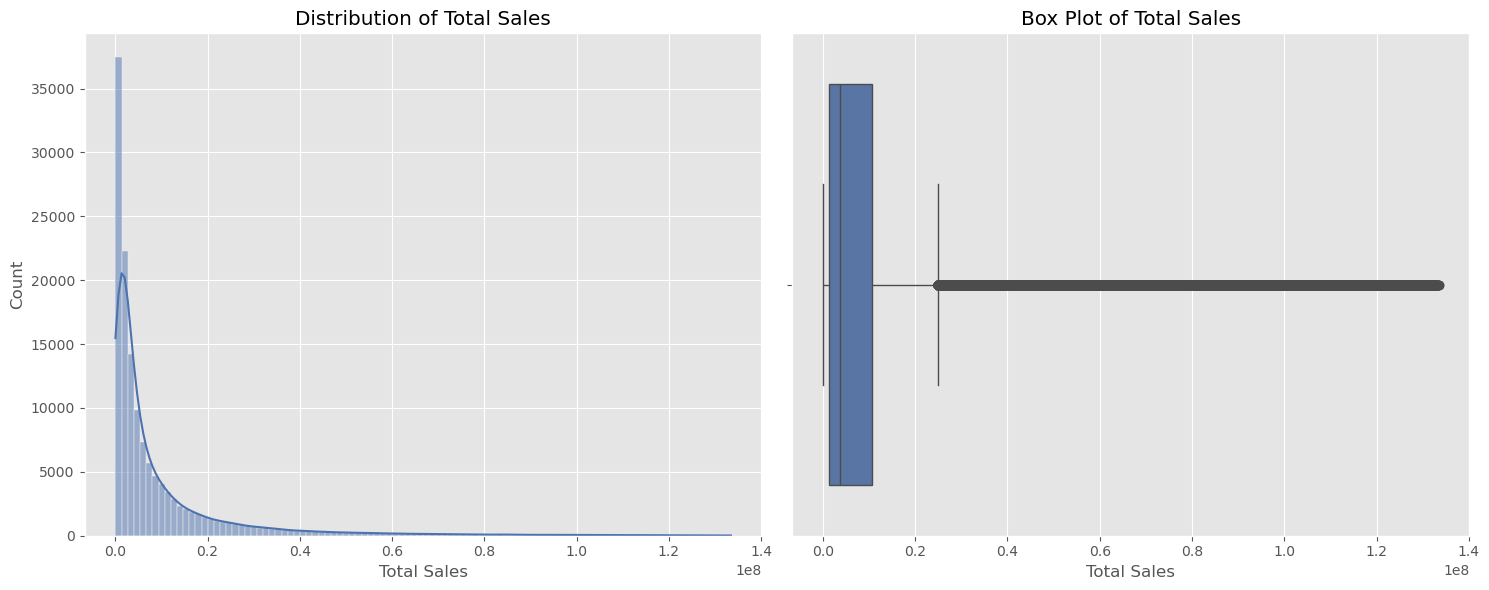

In [37]:
# Summary statistics for total_sales
total_sales_summary = df['total_sales'].describe()
total_sales_summary

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check for extreme values or outliers
print(df['total_sales'].describe())

# Filter the data to remove extreme outliers for better visualization
filtered_df = df[df['total_sales'] <= df['total_sales'].quantile(0.99)]

# Create a figure with subplots
plt.figure(figsize=(15, 6))

# Histogram of total_sales
plt.subplot(1, 2, 1)
sns.histplot(filtered_df['total_sales'], bins=100, kde=True)
plt.title('Distribution of Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Count')

# Boxplot of total_sales
plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_df['total_sales'])
plt.title('Box Plot of Total Sales')
plt.xlabel('Total Sales')

plt.tight_layout()
plt.show()



Initial remarks on target variable - total_sales

- Summary Statistics: The mean (average) total sales is approximately 1233.83 units.  The median (middle value) is lower at 372 units, indicating a right-skewed distribution.  The standard deviation is quite large (3,062.71), reflecting significant variability in total sales across different cinema showings.  The minimum sales recorded are 2 units, and the maximum is an exceptionally high at 126,281.99 units.
- Distribution Plot: The histogram shows a right-skewed distribution. Most cinema showings have relatively low total sales, with a few showings achieving very high sales.
- Box Plot: The box plot reveals numerous outliers on the higher end of total sales. These outliers represent cinema showings with exceptionally high sales compared to the typical range.
- Interpretation: The skewness in the distribution suggests that while most of the cinema showings generate modest revenue, there are a significant number of showings (possibly big-ticket films or special screenings) that generate much higher sales.  The presence of outliers indicates that certain events or movies might be extremely popular, driving exceptionally high sales.

### Numeric Features

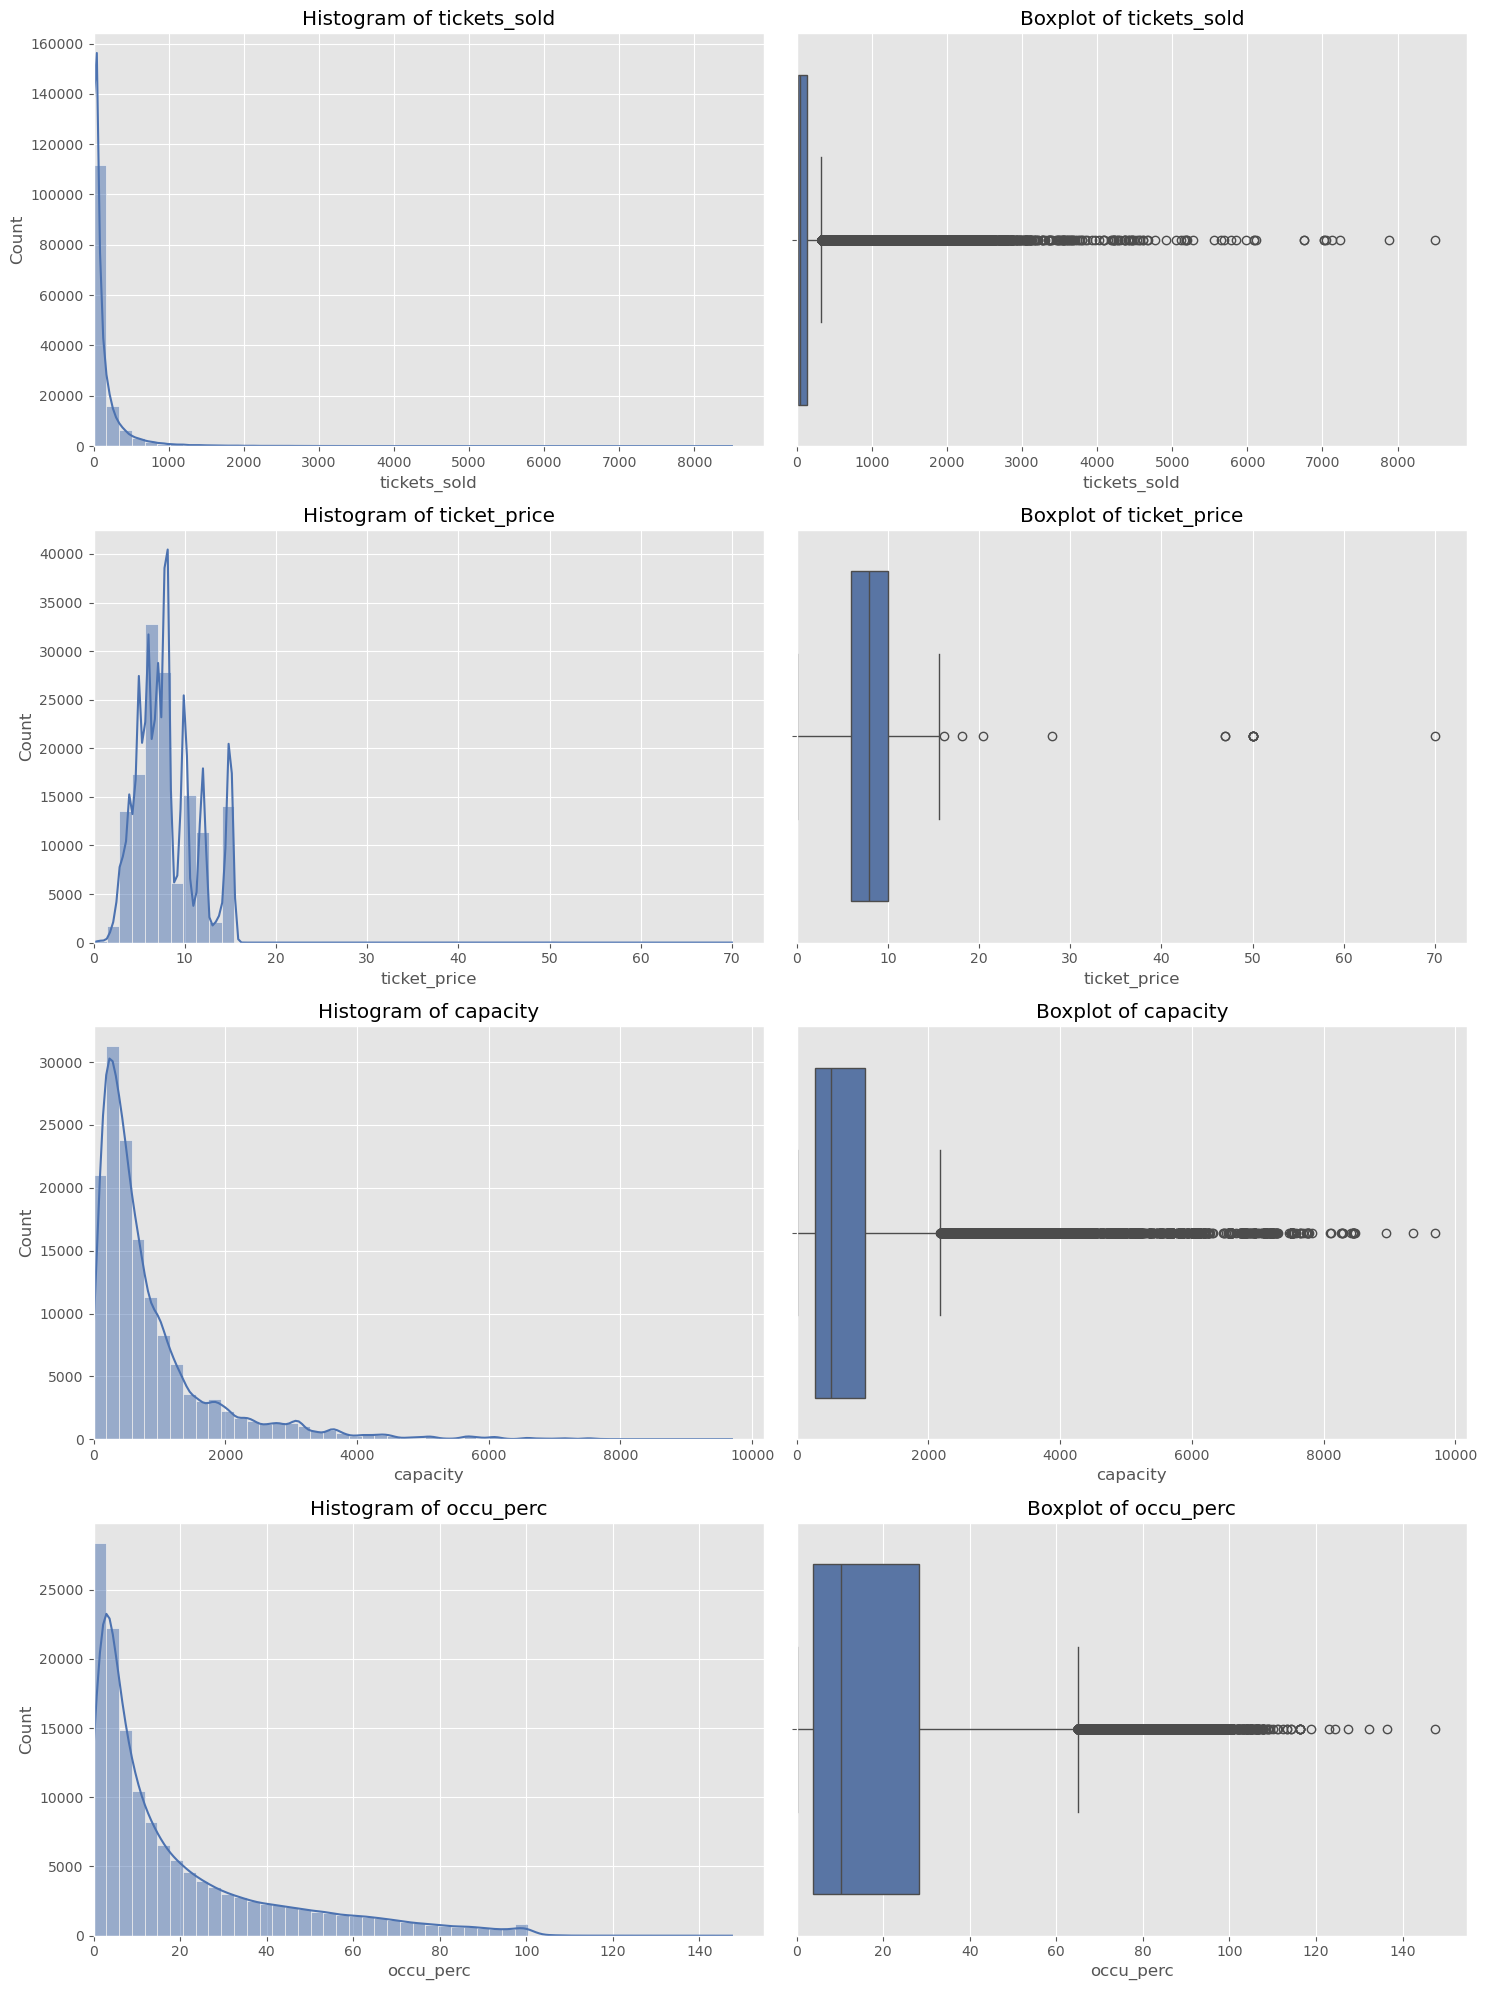

In [40]:
# Select variables for univariate analysis
variables_for_univariate_analysis = ['tickets_sold', 'ticket_price', 'capacity', 'occu_perc']

# Set the color palette
sns.set_palette("deep")

# Set the number of bins for histograms
num_bins = 50

# Create histograms and boxplots for each variable
fig, axes = plt.subplots(len(variables_for_univariate_analysis), 2, figsize=(15, 5 * len(variables_for_univariate_analysis)))

# Loop through variables in list
for i, col in enumerate(variables_for_univariate_analysis):
    # Histogram
    sns.histplot(df[col], bins=num_bins, ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Histogram of {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    
    # Adjust x-axis limit for histograms if needed (optional)
    axes[i, 0].set_xlim(left=0)

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].set_xlabel(col)
    
    # Adjust x-axis limit for boxplots if needed (optional)
    axes[i, 1].set_xlim(left=0)

# Adjust for tight layout
plt.tight_layout()
plt.show()


In [41]:
# Summary statistics for these variables
print(df[variables_for_univariate_analysis].describe())

        tickets_sold   ticket_price       capacity      occu_perc
count  142295.000000  142295.000000  142295.000000  142295.000000
mean      140.097944       8.123900     854.570014      19.955645
std       279.704392       3.323940     952.940018      22.648393
min         1.000000       0.048387      -2.000000       0.000000
25%        18.000000       6.000000     276.497696       3.750000
50%        50.000000       7.944827     525.131283      10.340000
75%       143.000000      10.000000    1038.961039      28.210000
max      8499.000000      70.000000    9692.097160     147.500000


Distributions of Key Numerical Variables:

- tickets_sold, capacity, ticket_price and occu_perc show right-skewed distributions. This is evident from the histograms and density plots, where the majority of the data points are clustered towards the lower end of the scale.
    - capacity also shows some negative values that may require correction.
- occupancy, The presence of values exceeding 100% suggests there are anomalies or errors in the data that need to be addressed, as occupancy percentages should logically not exceed 100%.
- Such skewness might necessitate data transformation prior to modeling.

### Categorical Features

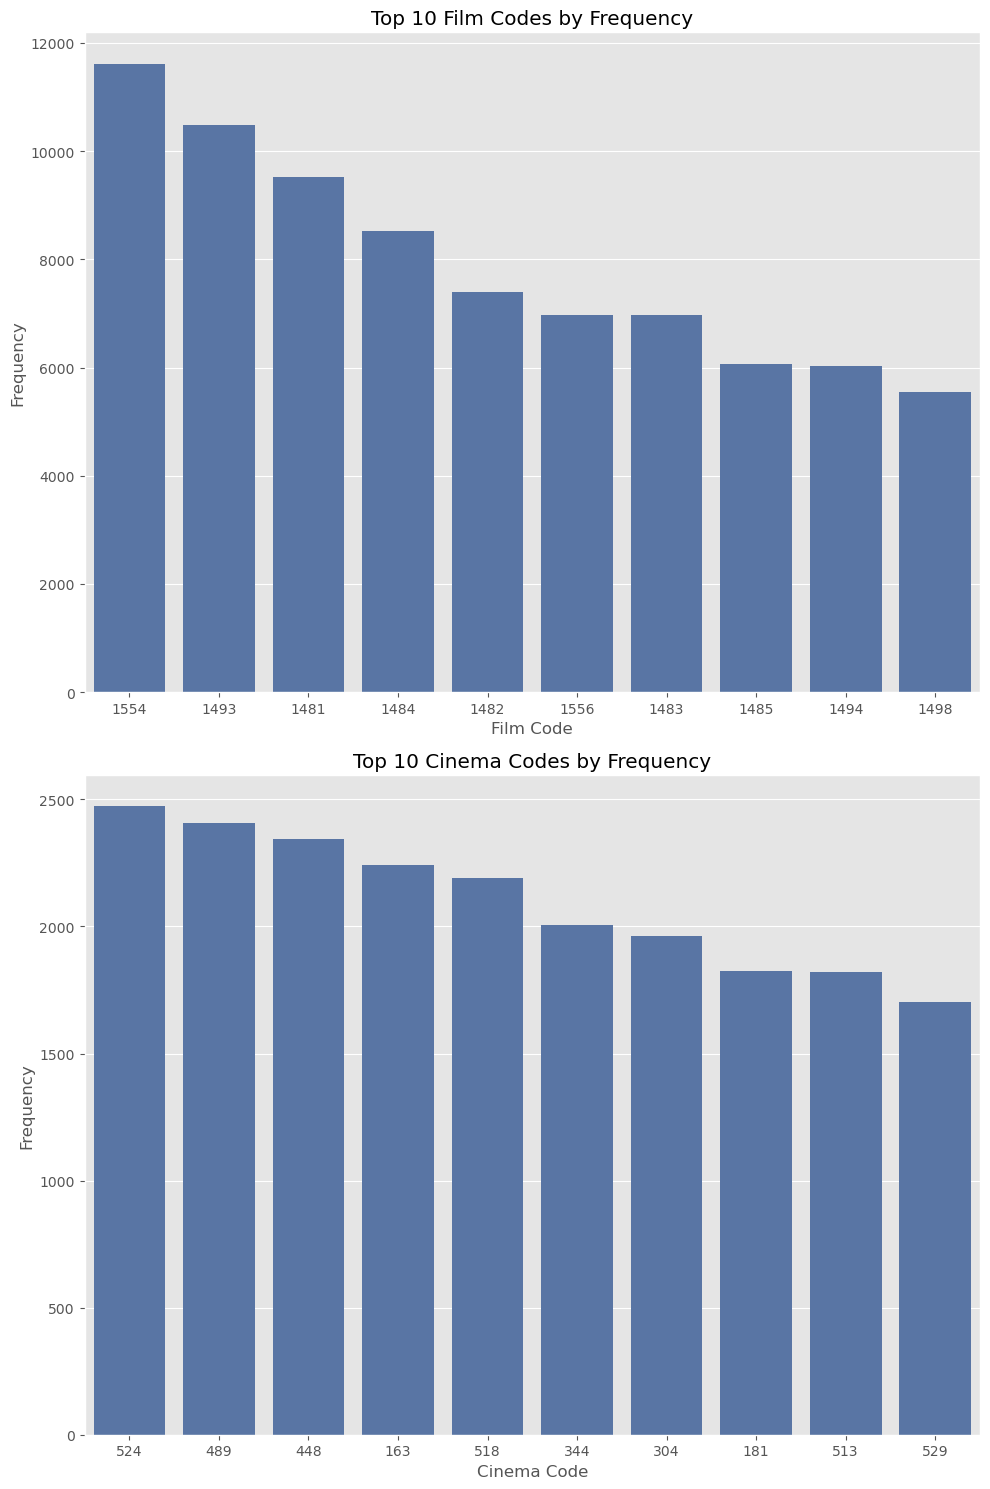

In [44]:
# Calculate frequency counts for film_code and cinema_code
film_code_counts = df['film_code'].value_counts().head(10)
cinema_code_counts = df['cinema_code'].value_counts().head(10)

# Create filtered DataFrames for top 10 film_codes and cinema_codes
top_10_film_df = df[df['film_code'].isin(film_code_counts.index)]
top_10_cinema_df = df[df['cinema_code'].isin(cinema_code_counts.index)]

# Create bar plots for the top 10 film_codes and cinema_codes
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Top 10 film_codes
sns.countplot(data=top_10_film_df, x='film_code', ax=axes[0], order=film_code_counts.index)
axes[0].set_title('Top 10 Film Codes by Frequency')
axes[0].set_xlabel('Film Code')
axes[0].set_ylabel('Frequency')

# Top 10 cinema_codes 
#palette = sns.color_palette("hsv", 10)  # Generate a color palette with 10 distinct colors
sns.countplot(data=top_10_cinema_df, x='cinema_code', ax=axes[1], order=cinema_code_counts.index)
#palette=palette)
axes[1].set_title('Top 10 Cinema Codes by Frequency')
axes[1].set_xlabel('Cinema Code')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


- Top 10 Film Codes by Frequency: This plot shows the ten most frequently occurring film codes in the dataset. The length of each bar represents the frequency of each film code.
- Top 10 Cinema Codes by Frequency: Similarly, the second plot illustrates the ten most common cinema codes. The frequency of each cinema code is indicated by the length of the bars.

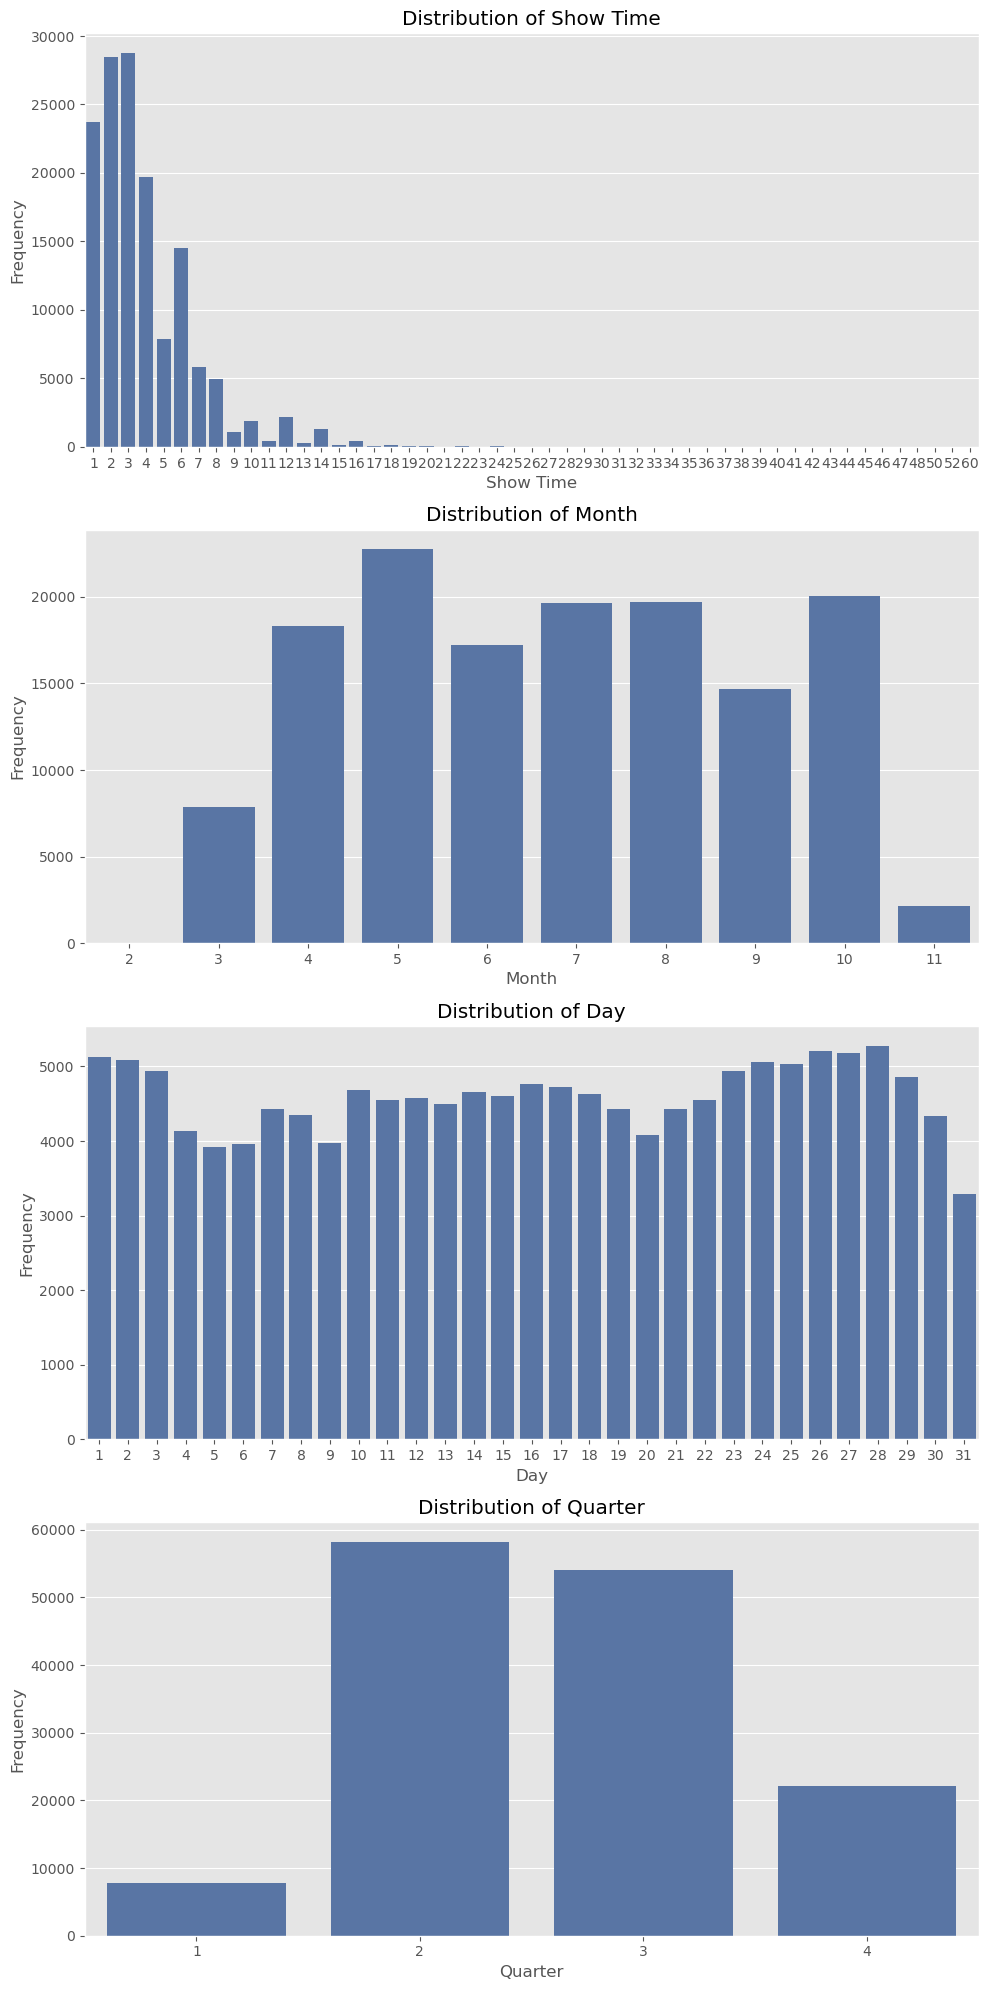

In [46]:
# Ensure that 'month' and 'day' are treated as integers for correct ordering
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)
df['show_time'] = df['show_time'].astype(int)

# Creating distribution plots for these temporal variables with ordered categories
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

# Show Time distribution
sns.countplot(data=df, x='show_time', ax=axes[0], order=sorted(df['show_time'].unique()))
axes[0].set_title('Distribution of Show Time')
axes[0].set_xlabel('Show Time')
axes[0].set_ylabel('Frequency')

# Month distribution
sns.countplot(data=df, x='month', ax=axes[1], order=sorted(df['month'].unique()))
axes[1].set_title('Distribution of Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Frequency')

# Day distribution
sns.countplot(data=df, x='day', ax=axes[2], order=sorted(df['day'].unique()))
axes[2].set_title('Distribution of Day')
axes[2].set_xlabel('Day')
axes[2].set_ylabel('Frequency')

# Quarter distribution
sns.countplot(data=df, x='quarter', ax=axes[3], order=sorted(df['quarter'].unique()))
axes[3].set_title('Distribution of Quarter')
axes[3].set_xlabel('Quarter')
axes[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


The distribution plots for the temporal variables show_time, month, and day are displayed:

- Show Time: Show times should be in a 24 or 12-hour range.  There are 215 showtimes that are over 24 hours (which are likley errors) and 2,641 that are between 13 and 24.  For the later, it appears these are in 24-hour date format, while nearly all the other times are in a 12-hour format (e.g. showtimes are from 12pm to 11pm, as most films aren't shown in the morning or past midnight).  This will need to be dealth with.
- Month: Since the data is from 2/21/2018 through 11/4/2018 (roughly 8 months), there is not data to be shown for the months of December or Januar, and February and November do not show a full months worth of data.
- Day: The distribution of days shows the spread of data across different days of the month. This can provide insights into whether certain days tend to have more screenings or higher attendance.
- Quarter: Since this is a function of month, it's probably not necessary, and there isn't a full quarter for February or November.

In [48]:
# Show stats for date/time-like columns
df[['month', 'day', 'quarter', 'show_time']].describe()

,month,day,show_time
count,142295.000000,142295.000000,142295.000000
mean,6.779978,16.106455,3.933357
std,2.193475,8.949366,3.056759
min,2.000000,1.000000,1.000000
25%,5.000000,8.000000,2.000000
50%,7.000000,16.000000,3.000000
75%,9.000000,24.000000,5.000000
max,11.000000,31.000000,60.000000


In [49]:
# Print number of showtimes between 12 and 24 military time
print(len(df.loc[(df['show_time'] > 12) & (df['show_time'] <= 24), 'show_time']))

# Print number of showtimes greater over 24 hours
print(len(df.loc[df['show_time'] > 24]))

2641
215


In [50]:
# Double check there are no missing values
df.isna().sum()

film_code       0
cinema_code     0
total_sales     0
tickets_sold    0
tickets_out     0
show_time       0
occu_perc       0
ticket_price    0
ticket_use      0
capacity        0
month           0
quarter         0
day             0
dtype: int64

## Bivariate Analysis

### Correlation

In [53]:
# Check correlations among numeric datatypes
df_numeric = df.select_dtypes(include=[int, float])

correlation_matrix = df_numeric.corr()
correlation_matrix

,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,day
total_sales,1.000000,0.915126,0.066949,0.510570,0.414309,0.271907,0.915062,0.376257,-0.079863,-0.000945
tickets_sold,0.915126,1.000000,0.071597,0.522458,0.493702,0.102925,0.999946,0.425518,-0.102949,-0.005475
tickets_out,0.066949,0.071597,1.000000,0.078917,0.044441,0.011996,0.061181,0.037631,-0.012542,0.004492
show_time,0.510570,0.522458,0.078917,1.000000,0.055602,0.176133,0.521995,0.681653,-0.023035,0.007484
occu_perc,0.414309,0.493702,0.044441,0.055602,1.000000,0.084356,0.493580,-0.141135,-0.144556,-0.011474
ticket_price,0.271907,0.102925,0.011996,0.176133,0.084356,1.000000,0.102871,0.004297,0.048888,0.000855
ticket_use,0.915062,0.999946,0.061181,0.521995,0.493580,0.102871,1.000000,0.425420,-0.102889,-0.005526
capacity,0.376257,0.425518,0.037631,0.681653,-0.141135,0.004297,0.425420,1.000000,-0.025028,0.006118
month,-0.079863,-0.102949,-0.012542,-0.023035,-0.144556,0.048888,-0.102889,-0.025028,1.000000,-0.160324
day,-0.000945,-0.005475,0.004492,0.007484,-0.011474,0.000855,-0.005526,0.006118,-0.160324,1.000000


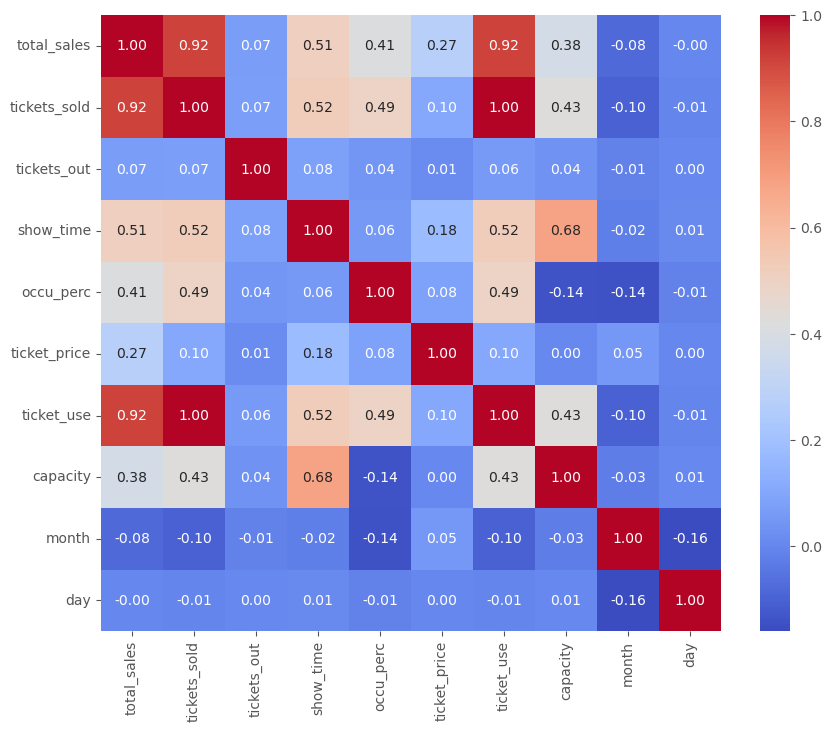

In [54]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

The heatmap reveals that the number of tickets sold and used, along with the total sales, are the most strongly correlated factors. Show time and capacity also show some significant positive relationships with these primary factors. However, ticket price, month, and day do not exhibit strong correlations with the main variables of interest.

### Numeric Relationships

In [57]:
print(df.index.min())
print(df.index.max())

2018-02-21 00:00:00
2018-11-04 00:00:00


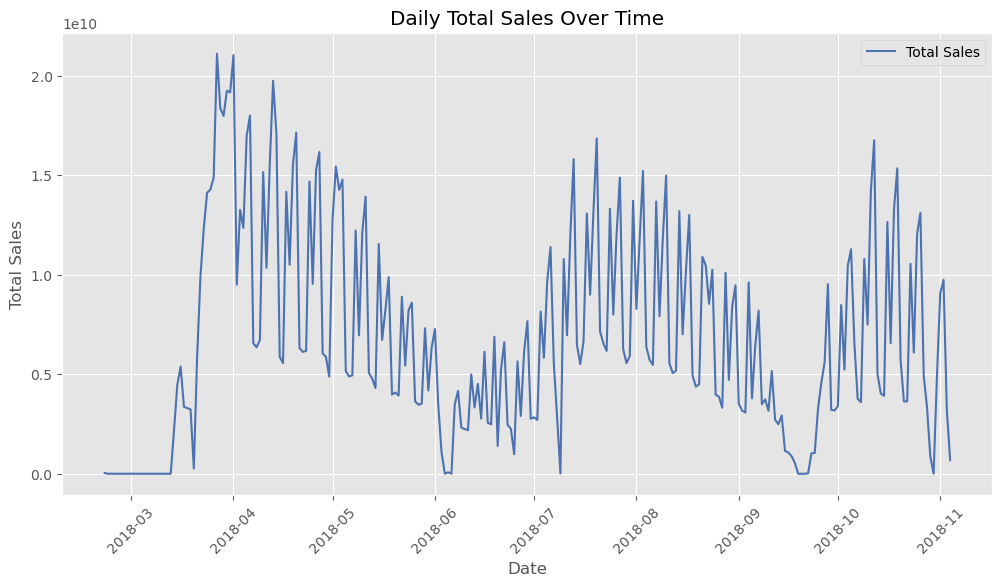

In [58]:
# Resample and aggregate data by day
daily_sales = df['total_sales'].resample('D').sum()

# Creating a time series plot of daily sales
plt.figure(figsize=(12, 6))
plt.plot(daily_sales, label='Total Sales')
plt.title('Daily Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=45)
plt.show()



- Date Range: The dataset spans from February 21, 2018, to November 4, 2018. This covers a period of about 8 months.
- Date Frequency: The most common frequency of records is consecutive days (0 days difference), with 142,061 instances, indicating that the data is primarily daily.
    - There are 228 instances where the dates are one day apart (1 day), suggesting occasional gaps in the data.
    - A few records have gaps of more than one day (2 days, 19 days, etc.), but these are relatively rare, indicating sporadic missing days in the dataset.
- Visualization - Data Distribution Over Time: The plot shows the number of records in the dataset resampled by day. It illustrates the daily distribution of the data, providing a visual indication of any fluctuations or trends in the number of records over time.

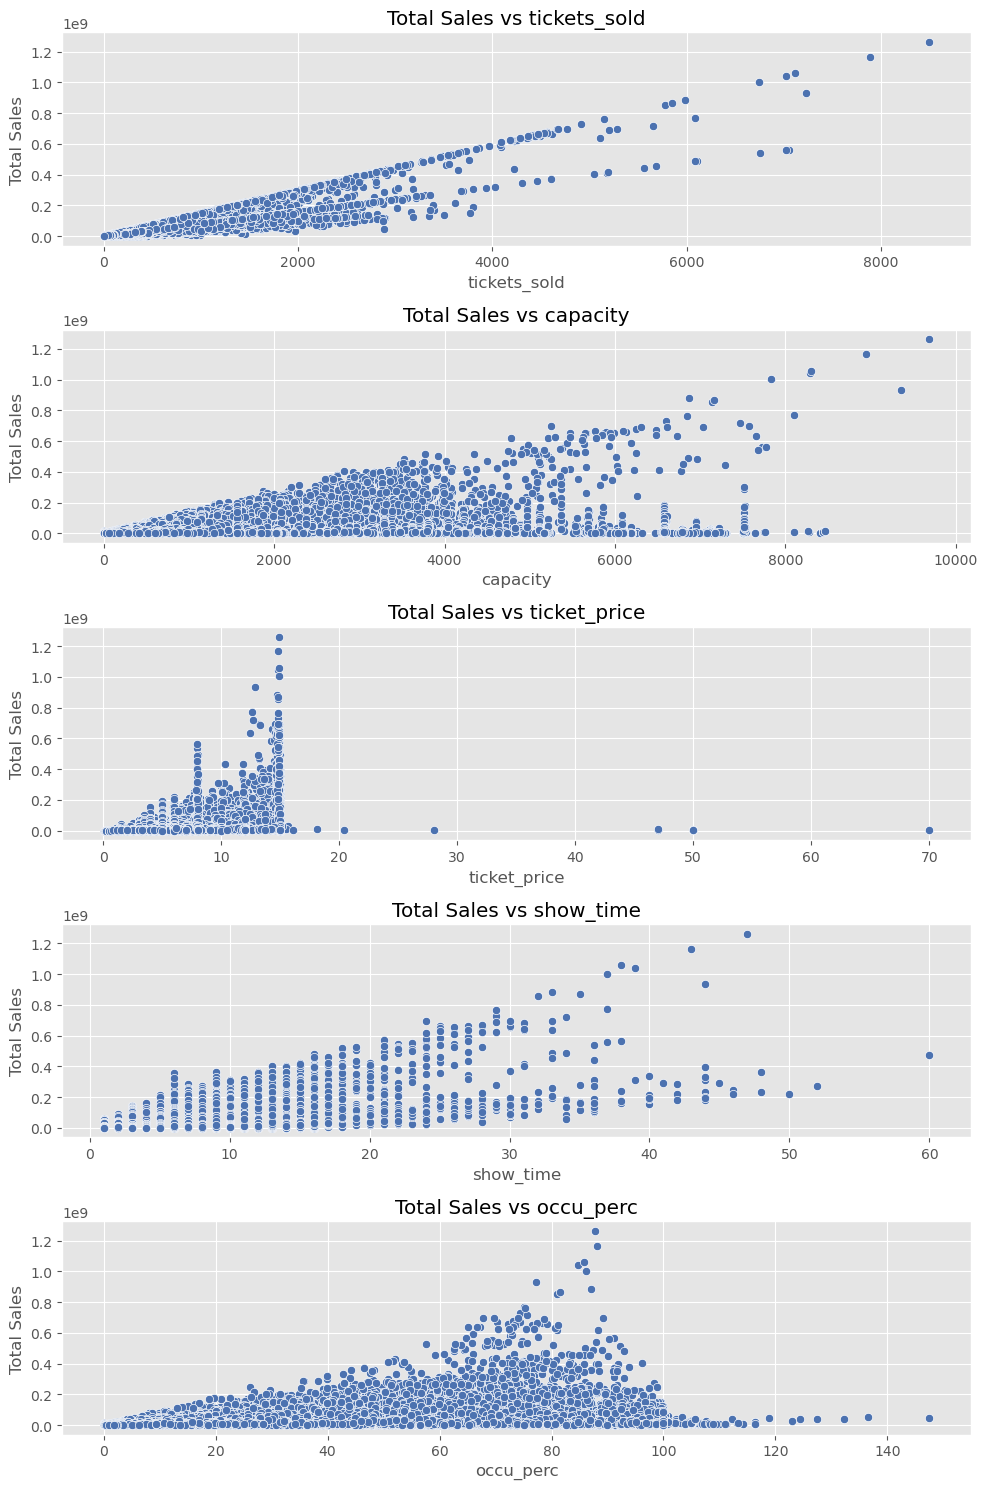

In [60]:
# Visualizing relationships between total_sales and other numerical variables

# Selecting numerical variables for relationship analysis
numerical_variables = ['tickets_sold', 'capacity', 'ticket_price', 'show_time', 'occu_perc']

# Creating scatter plots
fig, axes = plt.subplots(len(numerical_variables), 1, figsize=(10, 15))
for ax, col in zip(axes, numerical_variables):
    sns.scatterplot(x=df[col], y=df['total_sales'], ax=ax)
    ax.set_title(f'Total Sales vs {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Total Sales')
plt.tight_layout()
plt.show()




The scatter plots illustrate the relationships between total_sales and various numerical variables in the dataset:

- Tickets Sold (tickets_sold): There's a clear positive correlation with total_sales. As the number of tickets sold increases, total sales also increase, which is expected.  
    - Since we will be creating a regression model to predict total sales, features such as tickets sold, tickets out (ticket returns), and ticket use would not be known prior to the movie screenings.  Therefore, they should be elminated prior to modeling.
- Capacity (capacity): The relationship with capacity is less clear-cut. While higher capacity can lead to higher sales, it's not a direct or consistent relationship.
- Ticket Price (ticket_price): There appears to be a positive trend between ticket price and total sales. However, this relationship isn't as strong as with tickets_sold, indicating that factors other than just price influence sales.
- Show Time (show_time): The relationship between show_time (the number of times a film is shown) and total sales is somewhat positive, but with a lot of variability.
    - Show times should ideally be represented as valid times on a 12-hour or 24-hour clock.  Show times will be further analyzed during EDA.
- Occupancy Percentage (occu_perc): There is some positive correlation with total_sales, but it's not very strong. This indicates that while higher occupancy can lead to higher sales, it's not the sole determining factor.  
    - Occupancy percentage is another feature that would not be known until the movies are shown.  Thus, this feature should also be removed prior to modeling


### Categorical Relationships

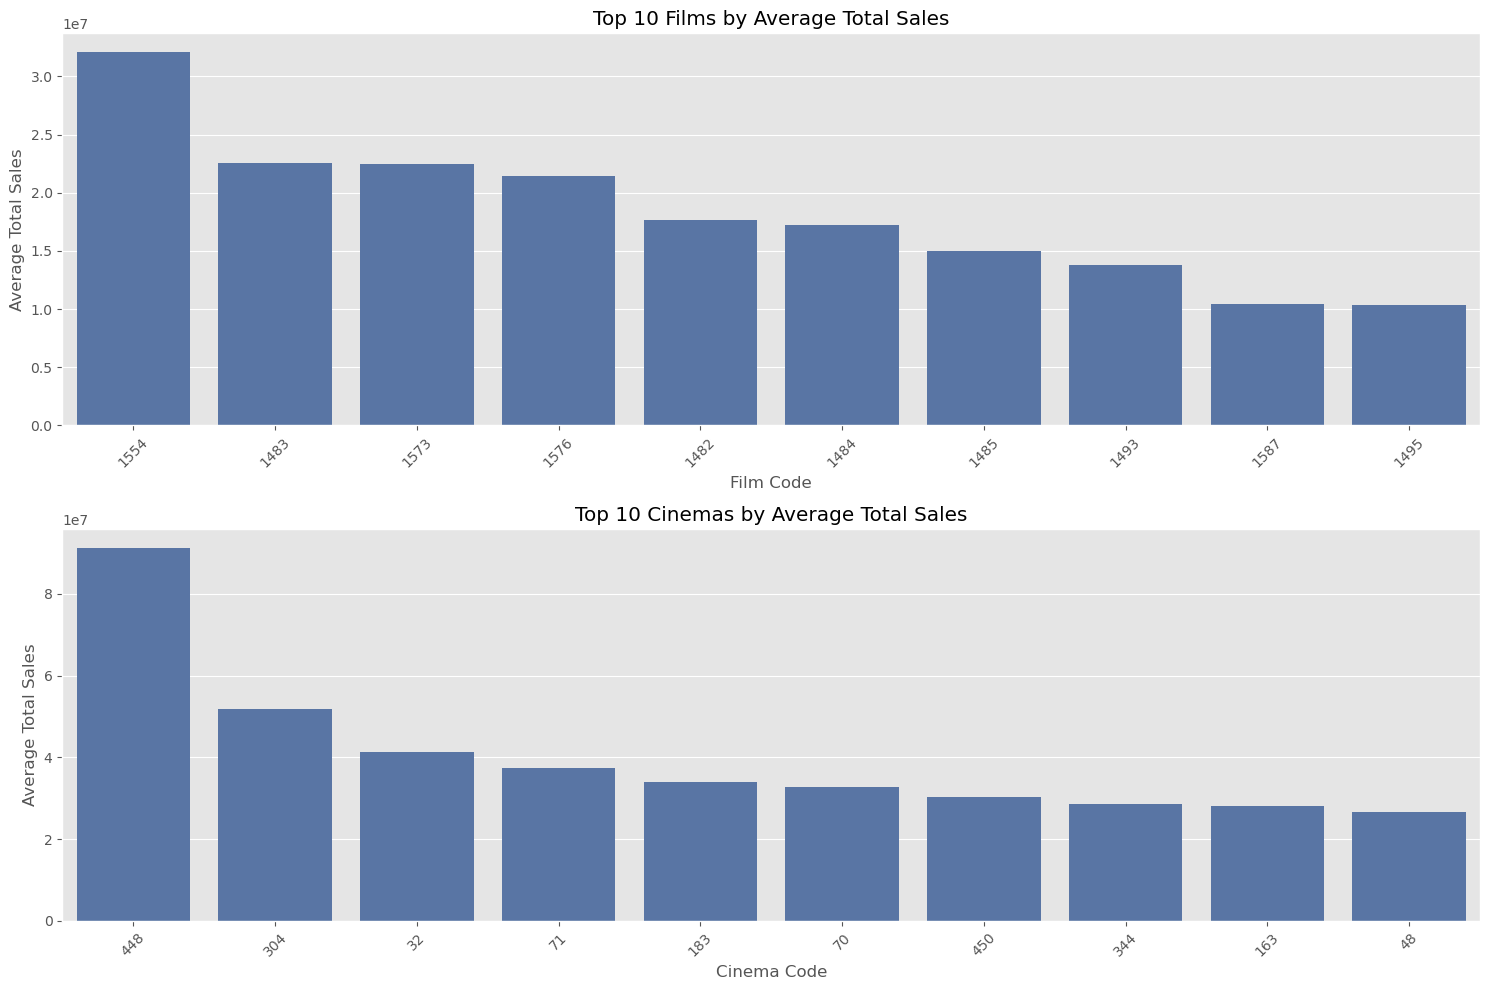

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame setup (your DataFrame will vary)
# df = pd.DataFrame({'film_code': ..., 'total_sales': ..., 'cinema_code': ...})

# Calculating average total_sales for each film_code and cinema_code
average_sales_film = df.groupby('film_code')['total_sales'].mean().sort_values(ascending=False)
average_sales_cinema = df.groupby('cinema_code')['total_sales'].mean().sort_values(ascending=False)

# Selecting the top 10 films and cinemas
top_10_films = average_sales_film.head(10)
top_10_cinemas = average_sales_cinema.head(10)

# Creating bar plots for the top 10 films and cinemas with correct x-axis labels
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Top 10 films - Correct x-axis labels
sns.barplot(x=top_10_films.index.astype(str), y=top_10_films.values, ax=axes[0])
axes[0].set_title('Top 10 Films by Average Total Sales')
axes[0].set_xlabel('Film Code')
axes[0].set_ylabel('Average Total Sales')
axes[0].set_xticks(range(len(top_10_films)))  # Setting tick positions
axes[0].set_xticklabels(top_10_films.index.astype(str), rotation=45)  # Setting tick labels

# Top 10 cinemas - Correct x-axis labels
sns.barplot(x=top_10_cinemas.index.astype(str), y=top_10_cinemas.values, ax=axes[1])
axes[1].set_title('Top 10 Cinemas by Average Total Sales')
axes[1].set_xlabel('Cinema Code')
axes[1].set_ylabel('Average Total Sales')
axes[1].set_xticks(range(len(top_10_cinemas)))  # Setting tick positions
axes[1].set_xticklabels(top_10_cinemas.index.astype(str), rotation=45)  # Setting tick labels

plt.tight_layout()
plt.show()



- Films: Film 154 is the clear leader in terms of average total sales, significantly outperforming others. The other top films have average sales ranging from around 15 to 25 million.
- Conemas: Cinema 448 stands out with average total sales over 80 million, while other top cinemas range between approximately 20 to 50 million.


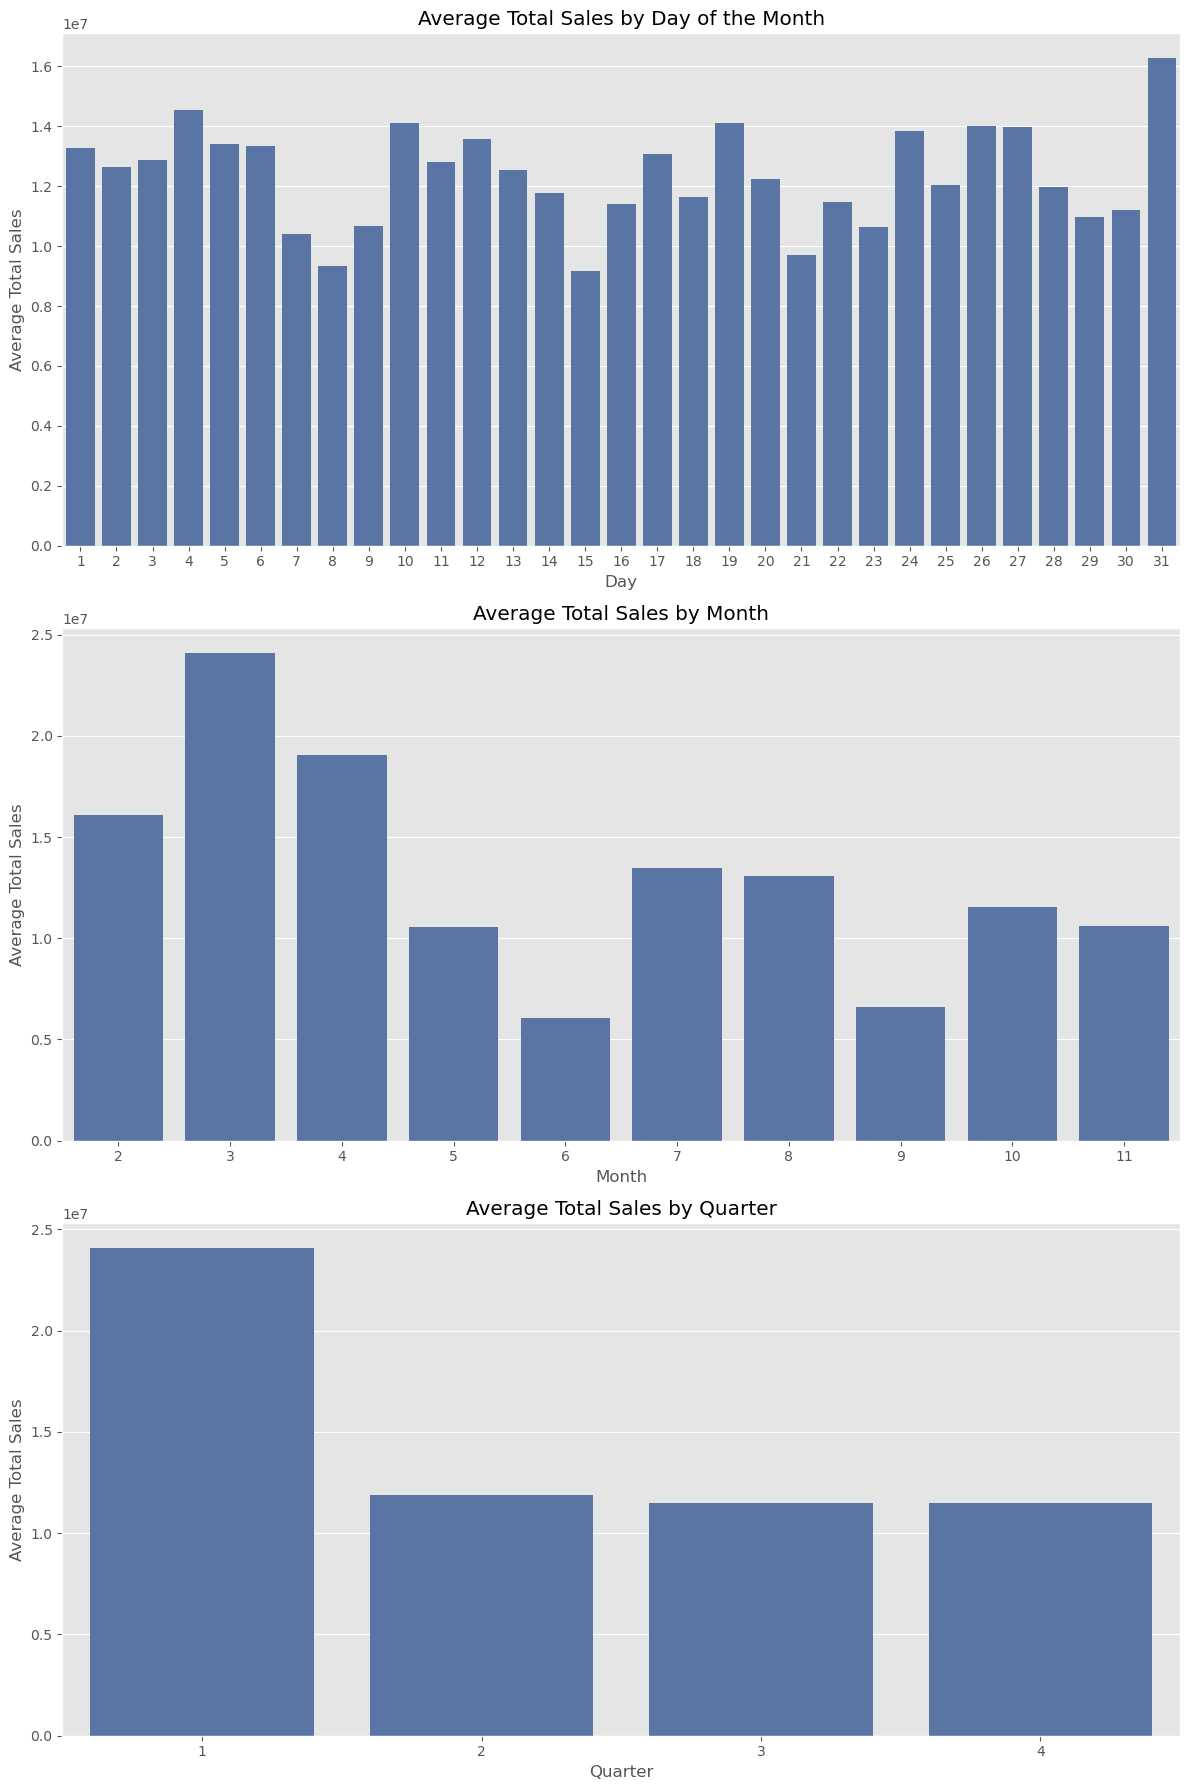

In [65]:
# Analyze total_sales in relation to temporal variables (day, month, quarter)

# Group data by day, month, and quarter and calculate average total sales
average_sales_day = df.groupby('day')['total_sales'].mean()
average_sales_month = df.groupby('month')['total_sales'].mean()
average_sales_quarter = df.groupby('quarter')['total_sales'].mean()

# Convert the day labels to integers for proper numerical sorting
average_sales_day.index = average_sales_day.index.astype(int)

# Sort the average_sales_day DataFrame by the day of the month
average_sales_day = average_sales_day.sort_index()

# Plot the trends
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Average sales by day
sns.barplot(x=average_sales_day.index, y=average_sales_day.values, ax=axes[0])
axes[0].set_title('Average Total Sales by Day of the Month')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Average Total Sales')

# Convert the month labels to integers for proper numerical sorting
average_sales_month.index = average_sales_month.index.astype(int)

# Sort the average_sales_month DataFrame by the month
average_sales_month = average_sales_month.sort_index()

# Average sales by month
sns.barplot(x=average_sales_month.index, y=average_sales_month.values, ax=axes[1])
axes[1].set_title('Average Total Sales by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Total Sales')

# Average sales by quarter
sns.barplot(x=average_sales_quarter.index, y=average_sales_quarter.values, ax=axes[2])
axes[2].set_title('Average Total Sales by Quarter')
axes[2].set_xlabel('Quarter')
axes[2].set_ylabel('Average Total Sales')

plt.tight_layout()
plt.show()


The bar plots for the temporal variables reveal interesting patterns in total_sales:

- Average Total Sales by Day of the Month: The sales seem relatively uniform across different days of the month, with slight variations. This suggests that the day of the month might not be a significant factor in influencing total sales.
- Average Total Sales by Month: There are noticeable differences in average sales across months. Certain months show higher average sales, which could be due to seasonal factors, holidays, or major film releases. This indicates a potential seasonal pattern in cinema sales.
- Average Total Sales by Quarter: Similar to the monthly analysis, different quarters exhibit varying average sales. Some quarters have notably higher sales, likely reflecting broader seasonal trends and holiday periods.

These temporal trends suggest that while the specific day of the month may not greatly impact sales, the time of year (reflected in the month and quarter) does. This can be valuable for planning and forecasting purposes, as it indicates when cinemas might expect higher or lower sales.


## Summary of Data Cleaning Adjustments

In [68]:
# Adjust showtime for validity

# Adjust show_time values
# Subtract 12 from show_time values between 13 and 24
df.loc[(df['show_time'] > 12) & (df['show_time'] <= 24), 'show_time'] -= 12

# Drop rows where 'show_time' exceeds 24
df = df[df['show_time'] <= 24]


In [69]:
# Fill negative theater capacity values with mean for that cinema_code

# Calculate the mean capacity for each cinema_code, excluding negative values
mean_capacity_per_cinema = df[df['capacity'] > 0].groupby('cinema_code')['capacity'].mean()

# Fill negative capacity values with the mean capacity of the corresponding cinema_code
df.loc[df['capacity'] < 0, 'capacity'] = df.loc[df['capacity'] < 0, 'cinema_code'].apply(
    lambda x: mean_capacity_per_cinema.get(x, np.nan)
)

# Handle cases where mean capacity is not available
df['capacity'].fillna(df['capacity'].mean(), inplace=True)

# Check if there are any negative values remaining in capacity
remaining_negative_capacity = df[df['capacity'] < 0].shape[0]

print(remaining_negative_capacity)

0


In [70]:
# Eliminate redundant/uunecessary columns
# tickets sold obviously bears a high correlation with total sales as tickets sales are a function of the total sales.  also the same type of issue with ticket_use and # tickets_out, 
# so drop these to avoid multicolineararility
df = df.drop(['tickets_sold', 'tickets_out', 'ticket_use'], axis=1)

# this feature is redundant since it can be calcualted from month
df = df.drop(columns=['quarter'])

# occupancy percentage is not known prior to sales being made
df = df.drop(columns=['occu_perc'])

# Final EDA

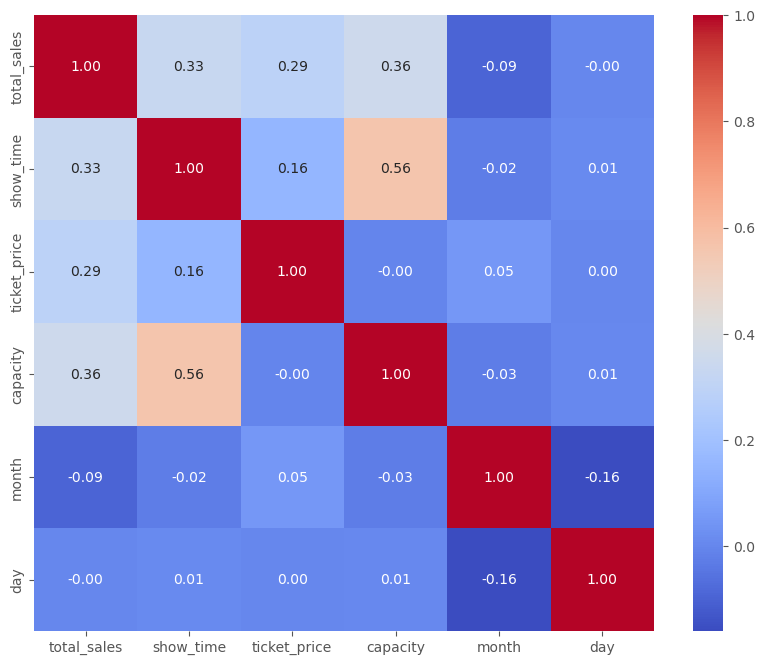

In [72]:
# check correlations among numeric datatypes
df_numeric = df.select_dtypes(include=[int, float])
correlation_matrix = df_numeric.corr()

# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


- Total Sales are most strongly influenced by capacity, show_time, and ticket_price.
- Show Time and apacity show a strong positive correlation, suggesting longer shows are held in larger venues.
- Ticket Price has moderate positive correlations with total_sales and show_time, indicating its role in revenue generation but not as significant as capacity or show time.
- Month and day show very weak or negligible correlations with other variables, indicating minimal impact on total sales or other factors.

In [74]:
# display final data types
df.dtypes

film_code       category
cinema_code     category
total_sales      float64
show_time          int32
ticket_price     float64
capacity         float64
month              int32
day                int32
dtype: object

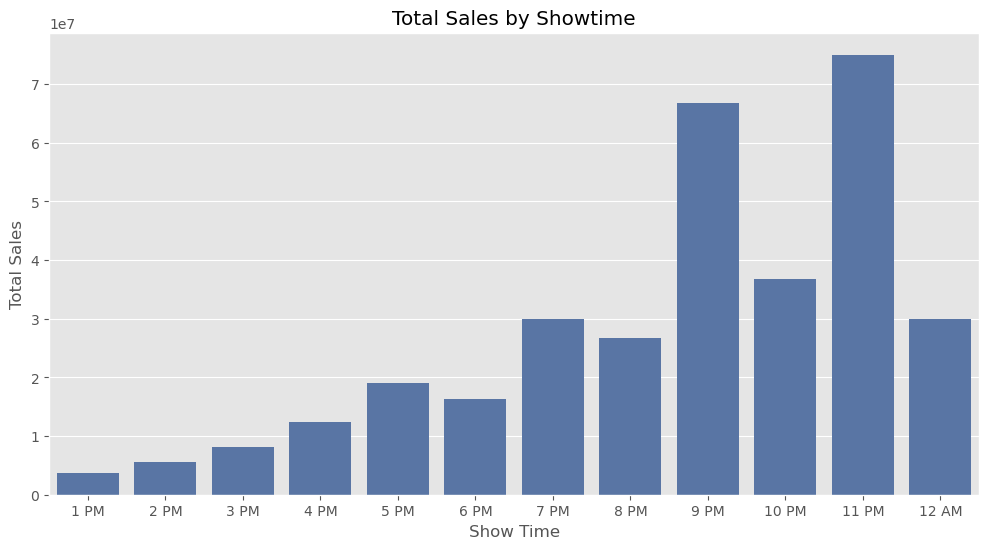

In [75]:
# Plot final showtimes

# Create a mapping of show_time integers to actual time strings
show_time_mapping = {
    1: '1 PM', 2: '2 PM', 3: '3 PM', 4: '4 PM', 5: '5 PM',
    6: '6 PM', 7: '7 PM', 8: '8 PM', 9: '9 PM', 10: '10 PM',
    11: '11 PM', 12: '12 AM'  # Assuming 12 represents midnight
}

# Apply the mapping to create a show_time_label column
df['show_time_label'] = df['show_time'].map(show_time_mapping)

# Sort the DataFrame based on the show_time column to ensure correct order in the plot
df_sorted = df.sort_values('show_time')

# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='show_time_label', y='total_sales', data=df_sorted, errorbar=('ci', False))

# Set the title and labels
plt.title('Total Sales by Showtime')
plt.xlabel('Show Time')
plt.ylabel('Total Sales')

# Rotate x-tick labels
# plt.xticks(rotation=45)

# Show the plot
plt.show()


- There is a noticeable variation in total sales across different showtimes. This suggests that the time at which a show is aired has an impact on the sales.
- The highest sales appear to occur during 9pm and 11pm showtimes, as indicated by the tallest bars. This might suggest prime time slots where attendance is highest, potentially due to more convenient times for the audience.


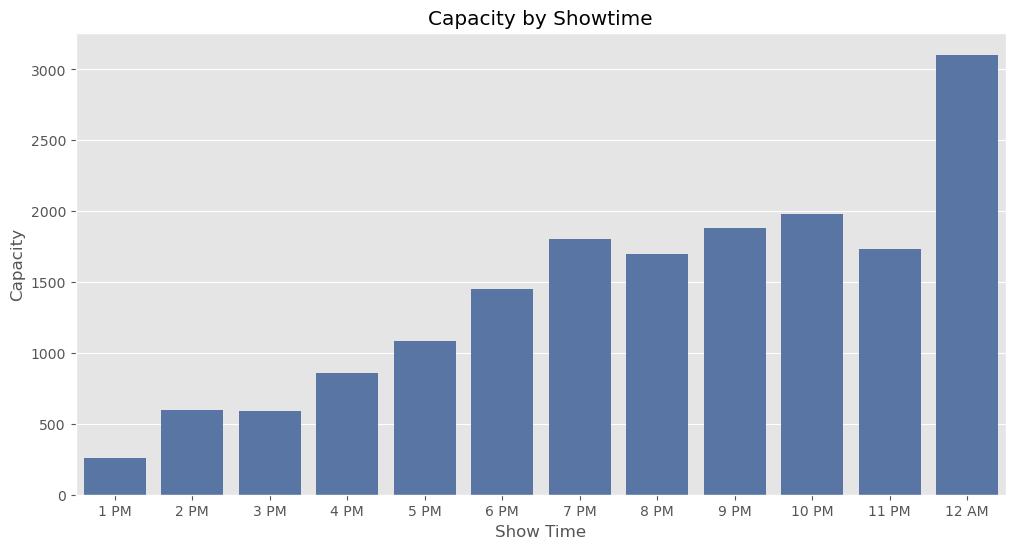

In [77]:
# Plot correlation of capacity by showtime

# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='show_time_label', y='capacity', data=df_sorted, errorbar=('ci', False))

# Set the title and labels
plt.title('Capacity by Showtime')
plt.xlabel('Show Time')
plt.ylabel('Capacity')

# Show the plot
plt.show()

- There is a gradual increase in capacity from the earliest showtimes (1 PM) towards the later showtimes.  The increase in capacity towards the evening and late night could indicate that larger theaters or additional screens are used during these times, which are typically peak hours for movie showings.
- The highest capacity is observed at the last showtime (12 AM), as indicated by the tallest bar on the plot.  The large capacity and high variability at 12 AM might be due to special showings, events, or specific days of the week that attract larger audiences.
- The capacity from 6 PM to 11 PM remains relatively consistent and does not fluctuate as much as the earliest and latest times.


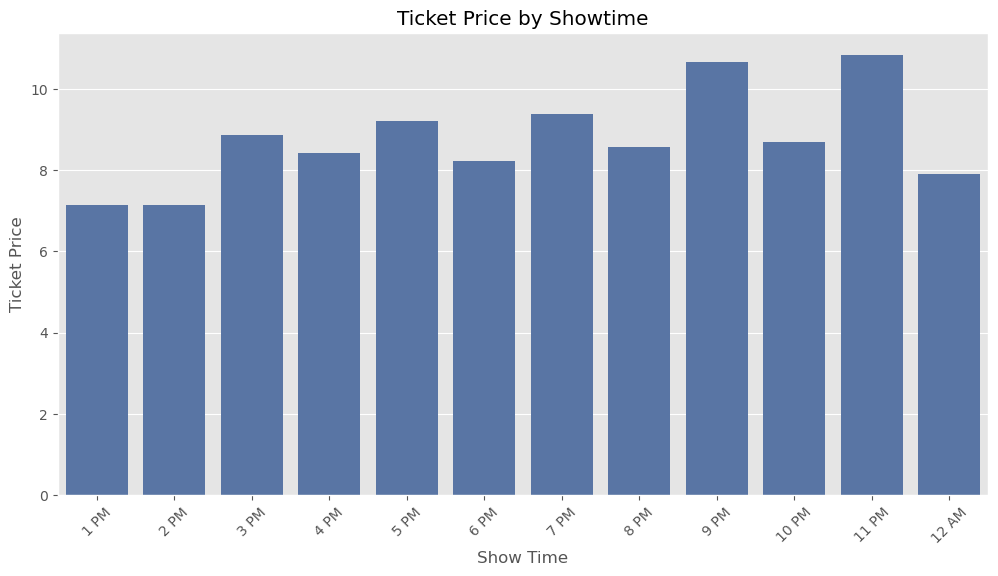

In [79]:
# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='show_time_label', y='ticket_price', data=df_sorted, errorbar=('ci', False))

# Set the title and labels
plt.title('Ticket Price by Showtime')
plt.xlabel('Show Time')
plt.ylabel('Ticket Price')

# Rotate x-tick labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Drop show_time_label column from dataframe (only needed for plots)
df = df.drop(columns=['show_time_label'])

- The ticket prices seem to increase from the earliest showtime (1 PM) and peak at the 9 PM showtime, indicating that evening showings might be priced higher, potentially due to higher demand during these hours.
- The highest average ticket price is observed at 9 PM, which may suggest a prime time pricing strategy where tickets for shows during popular hours are more expensive.
- Ticket prices from 1 PM to 7 PM are relatively consistent, with only a slight increase over these showtimes. This consistency could indicate a standard pricing strategy for matinee and early evening shows.

In [81]:
df.head()

,film_code,cinema_code,total_sales,show_time,ticket_price,capacity,month,day
date,,,,,,,,
2018-02-21,1471,448,32030000.0,2,11.996255,559.045226,2,21
2018-02-23,1471,518,180000.0,1,6.000000,144.927536,2,23
2018-03-14,1485,304,43200000.0,8,11.900826,1694.677871,3,14
2018-03-14,1483,83,300000.0,10,10.000000,1428.571429,3,14
2018-03-14,1483,262,560000.0,3,8.000000,958.904110,3,14


# Modeling

## Model Selection

- Due to the large number of outliers and distribution of key variables I chose to use Random Forest and Gradient Boosting models.  They are generally robust to the presence of outliers in the data. These models split the data based on the values of the features, making them less sensitive to the scale of the data and the presence of outliers.
- In addition, tree-based models inherently perform feature selection while building trees. Features that contribute more to splitting nodes and reducing impurities are considered more important by these models. This built-in mechanism of assessing feature importance is one of the advantages of using tree-based models.


## Preprocessing


In [86]:
# Use category encoders to encode categorical variables; otherwise too many features to handle (over 300)
import category_encoders as ce

# List of categorical columns to be binary encoded
categorical_columns = ['film_code', 'cinema_code', 'month', 'day']

# Create a Binary Encoder
binary_encoder = ce.BinaryEncoder(cols=categorical_columns)

# Fit and transform to produce binary encoded DataFrame
df_encoded = binary_encoder.fit_transform(df)

# Display the first few rows of the encoded DataFrame
df_encoded.head()


,film_code_0,film_code_1,film_code_2,film_code_3,film_code_4,film_code_5,cinema_code_0,cinema_code_1,cinema_code_2,cinema_code_3,...,capacity,month_0,month_1,month_2,month_3,day_0,day_1,day_2,day_3,day_4
date,,,,,,,,,,,,,,,,,,,,,
2018-02-21,0,0,0,0,0,1,0,0,0,0,...,559.045226,0,0,0,1,0,0,0,0,1
2018-02-23,0,0,0,0,0,1,0,0,0,0,...,144.927536,0,0,0,1,0,0,0,1,0
2018-03-14,0,0,0,0,1,0,0,0,0,0,...,1694.677871,0,0,1,0,0,0,0,1,1
2018-03-14,0,0,0,0,1,1,0,0,0,0,...,1428.571429,0,0,1,0,0,0,0,1,1
2018-03-14,0,0,0,0,1,1,0,0,0,0,...,958.904110,0,0,1,0,0,0,0,1,1


- Binary encoding was used for the categorical feature variables, as opposed to one-hot or dummy coding.  Binary encoding offers a balanced approach to handling categorical data for tree-based models, especially when dealing with high cardinality. It reduces the feature space compared to one-hot encoding, avoids the potential pitfalls of label encoding, and helps in maintaining the distinctness and importance of different categories without significantly increasing the complexity of the dataset.

In [88]:
# Train-test split
X = df_encoded.drop('total_sales', axis=1)
y = df_encoded['total_sales']

# Split Data into Features and Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [89]:
# confirm # of rows and columns
X_train.shape


(113664, 26)

## Random Forest Model

In [91]:
# Define parameter grid for random forest
param_grid = {
    'n_estimators': [100, 300, 500], 
    'max_features': ['sqrt', 'log2'],  
    'max_depth': [5, 10, 20, 50],  
    'min_samples_split': [2, 3, 5, 10],  
    'min_samples_leaf': [1, 2, 3, 4],  
    'bootstrap': [True, False]  # Limited to one option for simplicity
}

# Create base model to tune
rf = RandomForestRegressor()

# Set Randomized Search parameters
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)  # later increase iterations

# Fit the random search model
rf_random.fit(X_train, y_train)

# Print the best parameters
best_params = rf_random.best_params_
print(f"Best Parameters: {best_params}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}


In [92]:
# Fit and evaluate final model

# Fit the final model with the best parameters
final_rf = RandomForestRegressor(**best_params, random_state=42)
final_rf.fit(X_train, y_train)

# Make predictions with the final model
final_predictions = final_rf.predict(X_test)

# Evaluate the final model
mse_final = mean_squared_error(y_test, final_predictions)
r2_final = r2_score(y_test, final_predictions)

print(f"Final Random Forest Model - MSE: {mse_final}, R2: {r2_final}")


Final Random Forest Model - MSE: 124579140619203.64, R2: 0.8219201893851449


## Gradient Boosting Model

In [94]:
# Define the Parameter Grid of Randomized Search for Gradient Boosting Model
param_grid = {
    'n_estimators': [100, 300, 500],     
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 10, 20, 50],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2'],
    'subsample': [0.5, 0.6, 0.7]
}


In [95]:
# Perform Randomized Search
gb = GradientBoostingRegressor(random_state=42)

gb_random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_grid, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
gb_random_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.3, 0.5],
                                        'max_depth': [3, 10, 20, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 5, 10],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': [0.5, 0.6, 0.7]},
                   random_state=42, verbose=2)

In [96]:
# Retrieve the Best Model and Parameters

# Best hyperparameters
print("Best Hyperparameters:", gb_random_search.best_params_)

# Best model
best_gb = gb_random_search.best_estimator_


Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 10, 'learning_rate': 0.1}


In [97]:
# Fit the Final Model and Make Predictions

# Fit the best model
best_gb.fit(X_train, y_train)

# Make predictions with the best model
predictions_best_gb = best_gb.predict(X_test)


In [98]:
# Evaluate the Final Model

# Evaluation
mse_best_gb = mean_squared_error(y_test, predictions_best_gb)
r2_best_gb = r2_score(y_test, predictions_best_gb)

print(f"Final Gradient Boosting Model with Optimized Parameters - MSE: {mse_best_gb}, R2: {r2_best_gb}")


Final Gradient Boosting Model with Optimized Parameters - MSE: 117364486211913.06, R2: 0.8322331862810626


# Model Results

## Actual vs Forecasted Sales

In [ ]:
'''

# Make predictions with the final model
final_predictions = final_rf.predict(X_test)

# Make predictions with the best model
predictions_best_gb = best_gb.predict(X_test)

'''


###Model Predictions

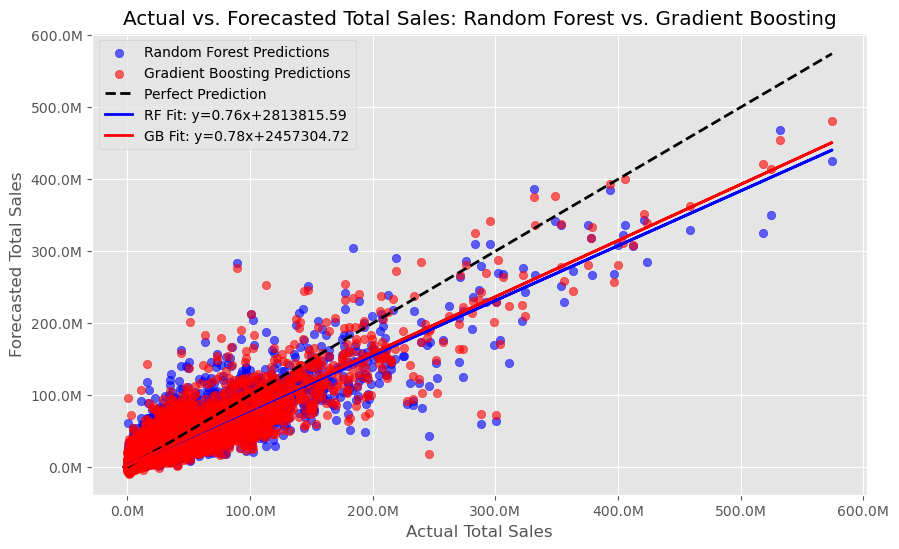

Random Forest - Mean Squared Error: 124,579,140,619,203.64
Random Forest - R^2 Score: 0.8219
Gradient Boosting - Mean Squared Error: 117,364,486,211,913.06
Gradient Boosting - R^2 Score: 0.8322


In [211]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import FuncFormatter

# Assuming final_predictions contains the predictions from the Random Forest model on X_test
# Assuming predictions_best_gb contains the predictions from the Gradient Boosting model on X_test
# Also assuming y_test contains the actual values of the target variable

# Make predictions (assuming these steps are already done in your notebook)
# final_predictions = final_rf.predict(X_test)
# predictions_best_gb = best_gb.predict(X_test)

# Function to format the axis labels
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fB' % (x * 1e-9)

# Plot actual vs. forecasted values
plt.figure(figsize=(10, 6))

# Scatter plot for Random Forest predictions
plt.scatter(y_test, final_predictions, alpha=0.6, label='Random Forest Predictions', color='b')

# Scatter plot for Gradient Boosting predictions
plt.scatter(y_test, predictions_best_gb, alpha=0.6, label='Gradient Boosting Predictions', color='r')

# Plot the perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')

# Calculate the regression line for Random Forest predictions
slope_rf, intercept_rf = np.polyfit(y_test, final_predictions, 1)
plt.plot(y_test, slope_rf * y_test + intercept_rf, color='blue', linewidth=2, label=f'RF Fit: y={slope_rf:.2f}x+{intercept_rf:.2f}')

# Calculate the regression line for Gradient Boosting predictions
slope_gb, intercept_gb = np.polyfit(y_test, predictions_best_gb, 1)
plt.plot(y_test, slope_gb * y_test + intercept_gb, color='red', linewidth=2, label=f'GB Fit: y={slope_gb:.2f}x+{intercept_gb:.2f}')

# Format the x and y axis to show millions or billions
formatter = FuncFormatter(millions)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Labels and title
plt.xlabel('Actual Total Sales')
plt.ylabel('Forecasted Total Sales')
plt.title('Actual vs. Forecasted Total Sales: Random Forest vs. Gradient Boosting')
plt.legend()

plt.show()

# Calculate and print evaluation metrics for Random Forest
mse_rf = mean_squared_error(y_test, final_predictions)
r2_rf = r2_score(y_test, final_predictions)
print(f'Random Forest - Mean Squared Error: {mse_rf:,.2f}')
print(f'Random Forest - R^2 Score: {r2_rf:.4f}')

# Calculate and print evaluation metrics for Gradient Boosting
mse_gb = mean_squared_error(y_test, predictions_best_gb)
r2_gb = r2_score(y_test, predictions_best_gb)
print(f'Gradient Boosting - Mean Squared Error: {mse_gb:,.2f}')
print(f'Gradient Boosting - R^2 Score: {r2_gb:.4f}')




The figure visually demonstrates that both Random Forest and Gradient Boosting models provide reasonable predictions of total sales, with similar trends and levels of accuracy. The regression lines and the scatter plots help in understanding the models' predictive behavior and areas where they may need further tuning or improvement.

## Performance

In [100]:
# Compare the performance of the two models

mse_rf = mean_squared_error(y_test, final_predictions)
r2_rf = r2_score(y_test, final_predictions)

print(f"Final Random Forest Model - MSE: {mse_rf}, R2: {r2_rf}")

mse_gb = mean_squared_error(y_test, predictions_best_gb)
r2_gb = r2_score(y_test, predictions_best_gb)

print(f"Final Gradient Boosting Model - MSE: {mse_gb}, R2: {r2_gb}")


Final Random Forest Model - MSE: 124579140619203.64, R2: 0.8219201893851449
Final Gradient Boosting Model - MSE: 117364486211913.06, R2: 0.8322331862810626


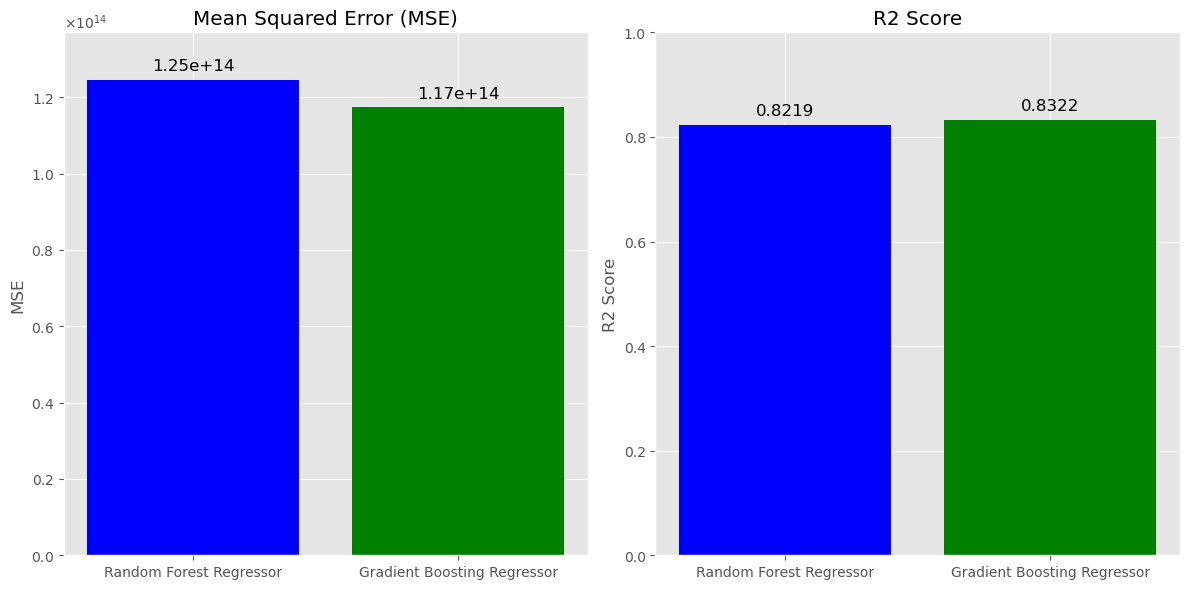

Random Forest - Mean Squared Error: 124,579,140,619,203.64
Random Forest - R^2 Score: 0.8219
Gradient Boosting - Mean Squared Error: 117,364,486,211,913.06
Gradient Boosting - R^2 Score: 0.8322


In [217]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Assuming mse_rf, mse_gb, r2_rf, and r2_gb are already defined

# Data for plotting
models = ['Random Forest Regressor', 'Gradient Boosting Regressor']
mse_values = [mse_rf, mse_gb]
r2_values = [r2_rf, r2_gb]

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# MSE Plot
axes[0].bar(models, mse_values, color=['blue', 'green'])
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_ylabel('MSE')
axes[0].set_ylim(0, max(mse_values) * 1.1)

# Format the y-axis with scientific notation
axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# Add MSE values on top of the bars
for i, v in enumerate(mse_values):
    axes[0].text(i, v + max(mse_values) * 0.02, f'{v:.2e}', ha='center', fontsize=12)

# R2 Score Plot
axes[1].bar(models, r2_values, color=['blue', 'green'])
axes[1].set_title('R2 Score')
axes[1].set_ylabel('R2 Score')
axes[1].set_ylim(0, 1)

# Add R2 values on top of the bars
for i, v in enumerate(r2_values):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics for Random Forest
mse_rf = mean_squared_error(y_test, final_predictions)
r2_rf = r2_score(y_test, final_predictions)
print(f'Random Forest - Mean Squared Error: {mse_rf:,.2f}')
print(f'Random Forest - R^2 Score: {r2_rf:.4f}')

# Calculate and print evaluation metrics for Gradient Boosting
mse_gb = mean_squared_error(y_test, predictions_best_gb)
r2_gb = r2_score(y_test, predictions_best_gb)
print(f'Gradient Boosting - Mean Squared Error: {mse_gb:,.2f}')
print(f'Gradient Boosting - R^2 Score: {r2_gb:.4f}')


- **Mean Squared Error (MSE):** The MSE for the Random Forest model is marginally higher than for the Gradient Boosting model. Since MSE measures the average squared difference between the predicted and actual values, a lower MSE is better. This suggests that the Gradient Boosting model has a slight edge in terms of predictive accuracy.
- **R2 Score:** The R2 score is a measure of the proportion of the variance in the dependent variable that is predictable from the independent variables. Both models have very similar R2 scores, with the Gradient Boosting model having a slight advantage. An R2 score closer to 1 indicates a model that explains more variance in the data.


## Feature Importances

In [104]:
# Extract feature importance
rf_importances = final_rf.feature_importances_
gb_importances = best_gb.feature_importances_


In [105]:
# create dataframe of feature importances
features = X_train.columns  # Column names of your features

importances_df = pd.DataFrame({
    'Feature': features,
    'RF Importance': rf_importances,
    'GB Importance': gb_importances
})

feature_column = 'Feature'
rf_importance_column = 'RF Importance'  
gb_importance_column = 'GB Importance' 

In [106]:
# Convert encoded features back to their original names

# List of all original features (categorical and non-categorical)
original_features = ['cinema_code', 'film_code', 'day', 'month', 'show_time', 'ticket_price', 'capacity']

# Create the mapping for encoded features
encoded_to_original = {}
for feature in original_features:
    for col in importances_df['Feature']:
        if col.startswith(feature):
            encoded_to_original[col] = feature

# Map encoded features to their original features
importances_df['Original_Feature'] = importances_df['Feature'].map(
    lambda x: encoded_to_original.get(x, x))  # Keep original feature if no mapping found

# Aggregate the importances
aggregated_rf_importances = importances_df.groupby('Original_Feature')['RF Importance'].sum()
aggregated_gb_importances = importances_df.groupby('Original_Feature')['GB Importance'].sum()

# Combine and sort the aggregated importances
aggregated_importances = pd.DataFrame({
    'Original_Feature': aggregated_rf_importances.index,
    'RF Importance': aggregated_rf_importances.values,
    'GB Importance': aggregated_gb_importances.values
}).sort_values(by='RF Importance', ascending=False)


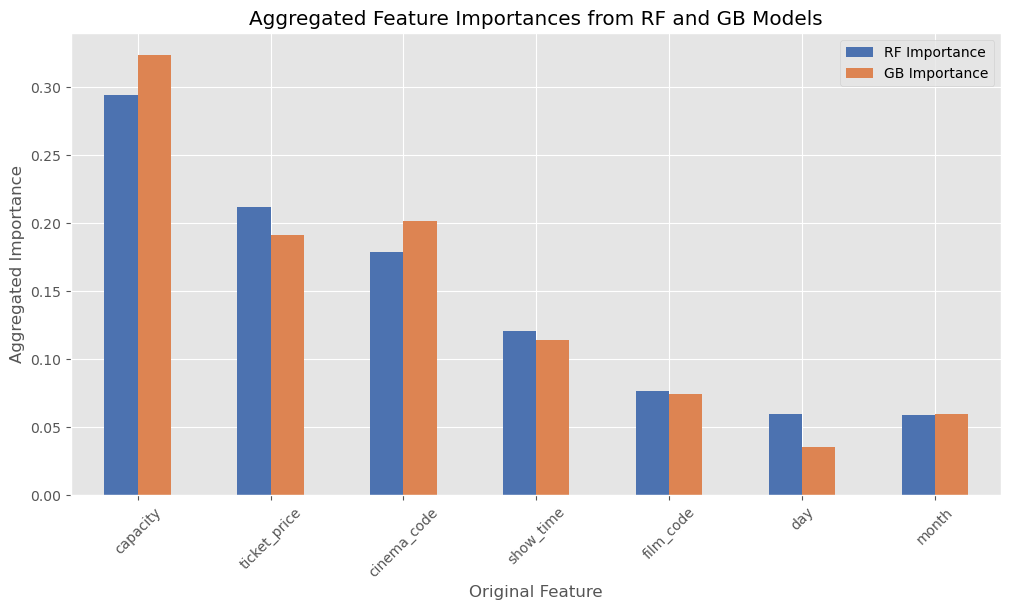

In [107]:
# Plot feature importances

aggregated_importances.plot(x='Original_Feature', kind='bar', figsize=(12, 6))
plt.title('Aggregated Feature Importances from RF and GB Models')
plt.xlabel('Original Feature')
plt.ylabel('Aggregated Importance')
plt.xticks(rotation=45)
plt.show()

**Summary of Feature Importances:**
- "Capacity" appears to be the most important feature for both RF and GB models, with GB giving it slightly more importance. This suggests that the number of seats available is a strong predictor of the target variable.
- "Ticket Price" is the second most important feature for both models. It has almost equal importance in both models, with slightly more importance for the RF model, indicating it's a significant predictor.
- "Cinema Code" has less importance than "Capacity" and "Ticket Price" but is still a relevant feature. The GB model seems to place slightly more emphasis on this feature compared to the RF model.
- "Show Time" is considered reasonably important by both models, with RF giving it a bit more importance than GB. This could indicate that the timing of the shows can affect the target variable.
- "Film Code" has moderate importance in both models, with RF assigning it slightly more importance than GB. This suggests that the specific film being shown has a role in the target variable, although not as strong as "Capacity" or "Ticket Price".
- "Day" appears to be of lower importance to both models, with RF giving it slightly more importance. This indicates that the day of the week may have a smaller, but still notable, influence on the target variable.
- "Month" has the least importance among the features for both models. Both RF and GB models do not seem to consider the month as a strong predictor of the target variable.

From these results, we can infer that the physical constraints and pricing (capacity and ticket price) are the most influential predictors. However, the specific cinema and showtime also play a role, potentially due to different cinema sizes, locations, or time-specific demand.  Furthermore, while the film itself and the day of the showing have some predictive power, they are less critical than the aforementioned features. Lastly, the month seems to have the least predictive power, which might suggest that the target variable is not strongly seasonal, or other features already capture the variance that month would otherwise explain.

# Business Implications and Insights

- **Capacity Optimization:**  Since 'Capacity' is the most significant predictor, it implies that cinemas with more seats have the potential to generate higher revenue. Cinemas should consider maximizing their seating capacity where possible. For smaller cinemas, focusing on optimizing seat occupancy could be key.

- **Pricing Strategy:** The high importance of 'Ticket Price' suggests that revenue is sensitive to pricing strategies. Dynamic pricing models could be implemented to adjust ticket prices based on demand, time of day, and film popularity.

- **Targeted Marketing for Cinemas:** The relevance of 'Cinema Code' indicates that specific cinemas perform differently in terms of revenue. Marketing efforts could be tailored to each cinema's audience, taking into account local demographics and preferences.

- **Show Time Optimization:** 'Show Time' holds a reasonable importance, hinting that certain times may be more profitable. Analyzing which show times are most popular could increase the number of screenings during those times.

In [111]:
# Time for code to execute

end_time = time.time()
total_time = end_time - start_time
print(f"Total runtime of the program is {total_time/60} minutes")


Total runtime of the program is 10.584253664811452 minutes
